# Building a categorical modelling pipeline

In [165]:
# import packages
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, FeatureUnion

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [141]:
df = pd.read_csv('SFE_data.csv', index_col=0)

In [142]:
df.shape

(933, 79)

In [143]:
# setting columns to categories
to_cat = ['MinTemp_uDP', 'MinTemp_u20', 'MaxTemp_uDP','MaxTemp_u20', 
          'MeanTemp_uDP', 'MeanTemp_u20', 'MinTemp_uDPSum_1', 'MinTemp_uDPSum_3', 
          'MinTemp_uDPSum_7','MaxTemp_uDPSum_1', 'MaxTemp_uDPSum_3', 'MaxTemp_uDPSum_7',
       'MeanTemp_uDPSum_1', 'MeanTemp_uDPSum_3', 'MeanTemp_uDPSum_7',
       'MinTemp_u20Sum_1', 'MinTemp_u20Sum_3', 'MinTemp_u20Sum_7',
       'MaxTemp_u20Sum_1', 'MaxTemp_u20Sum_3', 'MaxTemp_u20Sum_7',
       'MeanTemp_u20Sum_1', 'MeanTemp_u20Sum_3', 'MeanTemp_u20Sum_7','month', 'year', 'YearWeek']

for col in to_cat:
    df[col] = df[col].astype(object)

In [144]:
# drop columns that might lead to overfitting, as well as engineered categories with only one unique value
to_drop = ['Date', 'year', 'FieldID', 'JDay', 'MaxTemp_uDP', 'MeanTemp_uDP', 
           'MaxTemp_uDPSum_1',
       'MaxTemp_uDPSum_3', 'MaxTemp_uDPSum_7', 'MeanTemp_uDPSum_1',
       'MeanTemp_uDPSum_3', 'MeanTemp_uDPSum_7','MinTemp_u20', 'MinTemp_u20Sum_1',
       'MinTemp_u20Sum_3', 'MinTemp_u20Sum_7',]
df.drop(labels=to_drop, axis=1, inplace=True)

In [145]:
df.head()

,SsMean,Crop,MinTemp_y,MaxTemp_y,MeanTemp_y,MeanRH_y,Precip,Wind2,Wind10,Wind10Dir,...,MaxTemp_u20Sum_7,MeanTemp_u20Sum_1,MeanTemp_u20Sum_3,MeanTemp_u20Sum_7,SsMean_1,SsMean_3,SsMean_7,month,YearWeek,logSsMean
4,14.95,unknown,8.6,23.0,16.6,63.8,0.0,7.0,7.7,282.8,...,3.0,1.0,3.0,7.0,14.95,14.95,14.95,6,24,2.769459
5,9.71,unknown,9.0,22.7,15.7,72.6,0.1,9.0,10.5,166.6,...,2.0,1.0,3.0,7.0,14.95,14.95,14.95,6,25,2.371178
6,57.75,unknown,12.4,24.7,18.5,59.5,0.0,9.0,10.0,188.6,...,1.0,1.0,3.0,7.0,9.71,9.71,9.71,6,25,4.073291
7,6.67,unknown,6.9,27.1,18.5,62.6,0.0,10.4,12.2,160.4,...,1.0,1.0,3.0,7.0,57.75,27.47,27.47,6,25,2.037317
8,107.32,unknown,9.6,30.2,21.1,59.5,0.0,12.4,15.3,148.2,...,1.0,1.0,3.0,7.0,6.67,24.71,24.71,6,25,4.685090


In [7]:
df.columns

Index(['SsMean', 'Crop', 'MinTemp_y', 'MaxTemp_y', 'MeanTemp_y', 'MeanRH_y',
       'Precip', 'Wind2', 'Wind10', 'Wind10Dir', 'Frost', 'MeanDP_y',
       'MinTemp_uDP', 'MaxTemp_u20', 'MeanTemp_u20', 'MinTemp_1', 'MinTemp_3',
       'MinTemp_7', 'MaxTemp_1', 'MaxTemp_3', 'MaxTemp_7', 'MeanTemp_1',
       'MeanTemp_3', 'MeanTemp_7', 'MeanRH_1', 'MeanRH_3', 'MeanRH_7',
       'Precip_1', 'Precip_3', 'Precip_7', 'Wind2_1', 'Wind2_3', 'Wind2_7',
       'Wind10_1', 'Wind10_3', 'Wind10_7', 'Wind10Dir_1', 'Wind10Dir_3',
       'Wind10Dir_7', 'Frost_1', 'Frost_3', 'Frost_7', 'MeanDP_1', 'MeanDP_3',
       'MeanDP_7', 'PrecipSum_1', 'PrecipSum_3', 'PrecipSum_7',
       'MinTemp_uDPSum_1', 'MinTemp_uDPSum_3', 'MinTemp_uDPSum_7',
       'MaxTemp_u20Sum_1', 'MaxTemp_u20Sum_3', 'MaxTemp_u20Sum_7',
       'MeanTemp_u20Sum_1', 'MeanTemp_u20Sum_3', 'MeanTemp_u20Sum_7',
       'SsMean_1', 'SsMean_3', 'SsMean_7', 'month', 'YearWeek', 'logSsMean'],
      dtype='object')

#### Try Classification with 250 spore count threshold

In [146]:
# check for balance in dataset
print(df.loc[df['SsMean'] < 250].SsMean.count())
print(df.loc[df['SsMean'] >= 250].SsMean.count())

446
487


In [147]:
# create target label
def create_cat(data):
    if data < 250:
        return 0
    else:
        return 1
    
df['label'] = df['SsMean'].apply(create_cat)

In [148]:
# separate out target variable
X = df.drop(labels=['SsMean','logSsMean', 'label'], axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

In [149]:
# create pipelint

# select continuous and categorical varables
cat_feats = X.dtypes[X.dtypes == 'object'].index.tolist()
num_feats = X.dtypes[~X.dtypes.index.isin(cat_feats)].index.tolist()

# create functions to isolate datatypes
def numFeat(data):
    return data[num_feats]

def catFeat(data):
    return data[cat_feats]

# create fit_transform for feature functions
keep_num = FunctionTransformer(numFeat)
keep_cat = FunctionTransformer(catFeat)

# label encoder won't work in pipeline, will use one hot encoding
encoder = OneHotEncoder()

# will need to densify after encoding
class ToDenseTransformer():
    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
    def fit(self, X, y=None, **fit_params):
        return self
        
# select kbest
kbest = SelectKBest(k=30)

# select PCA components
pca = PCA(n_components=4)

# scale
scaler = StandardScaler()

In [150]:
# define pipeline
cat_preprocessing = Pipeline([
    ('cats', keep_cat),
    ('encode', encoder),
    ('densify', ToDenseTransformer())
])

num_preprocessing = Pipeline([
    ('nums', keep_num),
])

values_union = FeatureUnion([
    ('cat_cols', cat_preprocessing),
    ('num_cols', num_preprocessing),
])

feature_union = FeatureUnion([
    ('pca', pca),
    ('select_best', kbest)
])

### SVM, 250 threshold

In [151]:
# fit
base_model = SVC(probability=True)

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf68051f0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf680b850>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf56cf9d0>))]))])),
                ('scale', StandardScaler()),
                ('features'

Train accuracy: 0.7198391420911529
Test accuracy: 0.6363636363636364
Train auc: 0.8047582972582972
Test auc: 0.7134844322344323
Train precision: 0.7379134860050891
Test precision: 0.6185567010309279
Train recall: 0.7323232323232324
Test recall: 0.6593406593406593
F1 score train: 0.7351077313054499
F1 score test: 0.6382978723404256
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        96
           1       0.62      0.66      0.64        91

    accuracy                           0.64       187
   macro avg       0.64      0.64      0.64       187
weighted avg       0.64      0.64      0.64       187



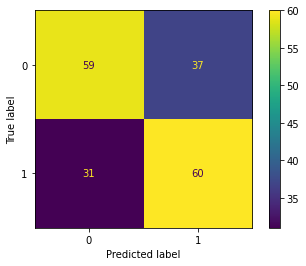

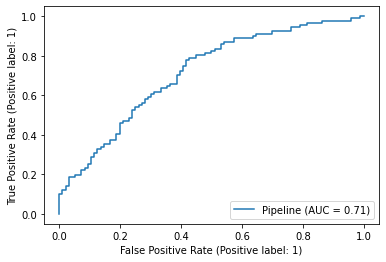

In [152]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

#### Logistic Regression, 250 threshold

In [96]:
# fit
base_model = LogisticRegression()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf15800d0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf135ca00>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf1580160>))]))])),
                ('scale', StandardScaler()),
                ('features'

Train accuracy: 0.7720588235294118
Test accuracy: 0.7165775401069518
Train auc: 0.8383456323705953
Test auc: 0.7924528301886793
Train precision: 0.7821350762527233
Test precision: 0.5
Train recall: 0.7542016806722689
Test recall: 0.660377358490566
F1 score train: 0.7679144385026738
F1 score test: 0.5691056910569106
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       134
           1       0.50      0.66      0.57        53

    accuracy                           0.72       187
   macro avg       0.67      0.70      0.68       187
weighted avg       0.75      0.72      0.73       187



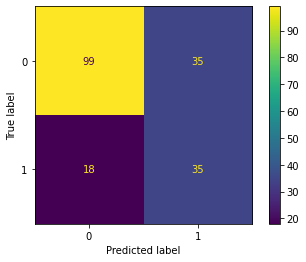

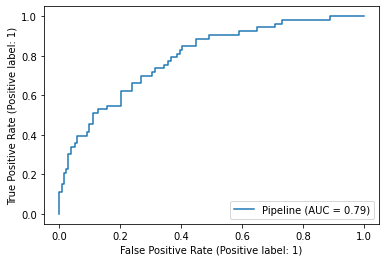

In [97]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

#### Naive Bayes, 250 threshold

In [98]:
# fit
base_model = GaussianNB()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf15800d0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf135ca00>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf1580160>))]))])),
                ('scale', StandardScaler()),
                ('features'

Train accuracy: 0.6974789915966386
Test accuracy: 0.6470588235294118
Train auc: 0.7851603876844856
Test auc: 0.7863981976907913
Train precision: 0.674074074074074
Test precision: 0.43434343434343436
Train recall: 0.7647058823529411
Test recall: 0.8113207547169812
F1 score train: 0.7165354330708661
F1 score test: 0.5657894736842106
              precision    recall  f1-score   support

           0       0.89      0.58      0.70       134
           1       0.43      0.81      0.57        53

    accuracy                           0.65       187
   macro avg       0.66      0.70      0.63       187
weighted avg       0.76      0.65      0.66       187



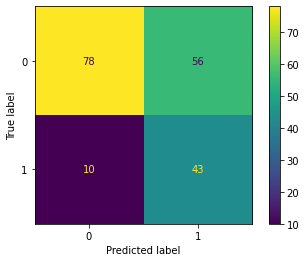

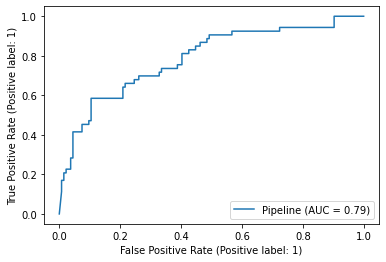

In [99]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

#### XGBoost, 250 threshold

In [107]:
# fit
base_model = xgb.XGBClassifier()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

[20:48:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf15800d0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf135ca00>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf1580160>))]))]))...
                               colsample_bytree=1, gamma=0, gpu_id=-1,

Train accuracy: 1.0
Test accuracy: 0.679144385026738
Train auc: 1.0
Test auc: 0.7318891218262289
Train precision: 1.0
Test precision: 0.7129629629629629
Train recall: 1.0
Test recall: 0.7264150943396226
F1 score train: 1.0
F1 score test: 0.7196261682242991
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        81
           1       0.71      0.73      0.72       106

    accuracy                           0.68       187
   macro avg       0.67      0.67      0.67       187
weighted avg       0.68      0.68      0.68       187



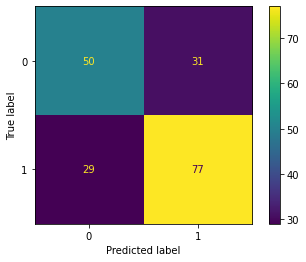

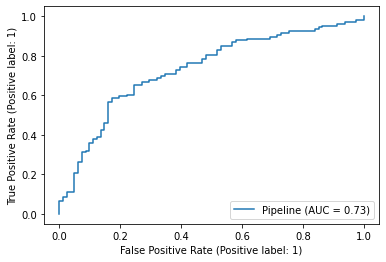

In [108]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

### Classification with 500 spore count threshold

In [153]:
print(df.loc[df['SsMean'] < 500].SsMean.count())
print(df.loc[df['SsMean'] >= 500].SsMean.count())

610
323


In [154]:
# create target 
def create_cat(data):
    if data < 500:
        return 0
    else:
        return 1
    
df['label'] = df['SsMean'].apply(create_cat)

In [155]:
# labels imbalanced
# create balanced train set, normal test set

# shuffle dataset
df = shuffle(df)
size = int(df.shape[0] * 0.8)
# split into test and train
train, test = df.iloc[:size].copy(), df.iloc[size:].copy()

In [156]:
train.shape

(746, 64)

In [157]:
test.shape

(187, 64)

In [158]:
print(train.loc[train['SsMean'] < 500].SsMean.count())
print(train.loc[train['SsMean'] >= 500].SsMean.count())

485
261


In [159]:
# create balanced train dataset
class_0 = train.loc[train['label']==0]
class_1 = train.loc[train['label']==1]

class_1_sample = class_1.sample(n=485, replace=True)

b_train = pd.concat([class_0, class_1_sample], axis=0)

In [160]:
b_train.shape

(970, 64)

In [161]:
print(b_train.loc[b_train['SsMean'] < 500].SsMean.count())
print(b_train.loc[b_train['SsMean'] >= 500].SsMean.count())

485
485


In [162]:
# separate out target variable
X_train = b_train.drop(labels=['SsMean','logSsMean', 'label'], axis=1)
X_test = test.drop(labels=['SsMean','logSsMean', 'label'], axis=1)
y_train = b_train.label
y_test = test.label

#### SVM, 500 threshold

In [163]:
base_model = SVC(probability=True)

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf68051f0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf680b850>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf56cf9d0>))]))])),
                ('scale', StandardScaler()),
                ('features'

Train accuracy: 0.7896907216494845
Test accuracy: 0.7486631016042781
Train auc: 0.8634711446487408
Test auc: 0.7747096774193548
Train precision: 0.7793240556660039
Test precision: 0.6119402985074627
Train recall: 0.8082474226804124
Test recall: 0.6612903225806451
F1 score train: 0.7935222672064777
F1 score test: 0.6356589147286821
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       125
           1       0.61      0.66      0.64        62

    accuracy                           0.75       187
   macro avg       0.72      0.73      0.72       187
weighted avg       0.75      0.75      0.75       187



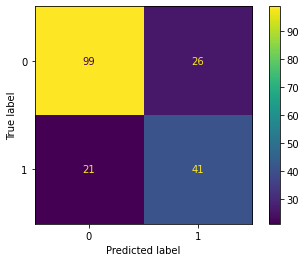

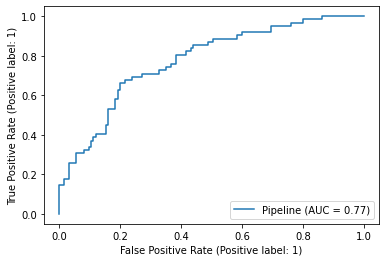

In [164]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

#### Logistic Regression, 500 Threshold

In [72]:
base_model = LogisticRegression()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    #('features', feature_union), # better performance with no feature selection
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf15800d0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf135ca00>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf1580160>))]))])),
                ('model', LogisticRegression())])

Train accuracy: 0.7542016806722689
Test accuracy: 0.7219251336898396
Train auc: 0.8177123790692749
Test auc: 0.7868206139115742
Train precision: 0.7922705314009661
Test precision: 0.5079365079365079
Train recall: 0.6890756302521008
Test recall: 0.6037735849056604
F1 score train: 0.7370786516853932
F1 score test: 0.5517241379310345
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       134
           1       0.51      0.60      0.55        53

    accuracy                           0.72       187
   macro avg       0.67      0.69      0.68       187
weighted avg       0.74      0.72      0.73       187



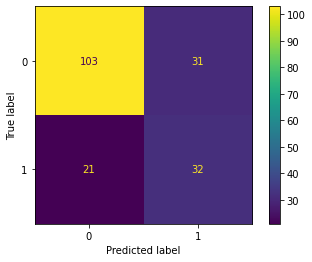

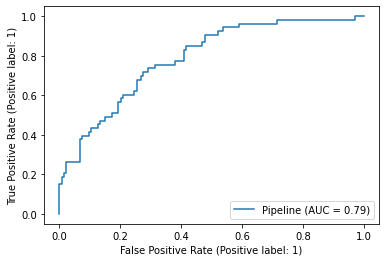

In [73]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

#### Naive Bayes, 500 Threshold

In [83]:
base_model = GaussianNB()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf15800d0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf135ca00>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf1580160>))]))])),
                ('scale', StandardScaler()),
                ('features'

Train accuracy: 0.6974789915966386
Test accuracy: 0.6470588235294118
Train auc: 0.7851692147447215
Test auc: 0.7863981976907913
Train precision: 0.674074074074074
Test precision: 0.43434343434343436
Train recall: 0.7647058823529411
Test recall: 0.8113207547169812
F1 score train: 0.7165354330708661
F1 score test: 0.5657894736842106
              precision    recall  f1-score   support

           0       0.89      0.58      0.70       134
           1       0.43      0.81      0.57        53

    accuracy                           0.65       187
   macro avg       0.66      0.70      0.63       187
weighted avg       0.76      0.65      0.66       187



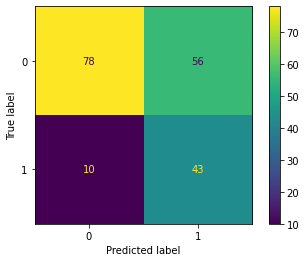

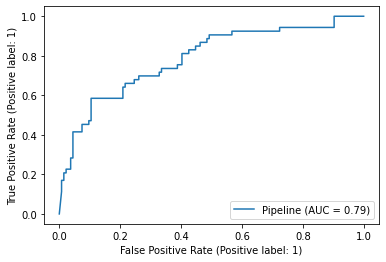

In [84]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

#### XGBoost, 500 threshold

In [91]:
base_model = xgb.XGBClassifier()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

pipeline.fit(X_train, y_train)

[20:40:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fabf15800d0>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7fabf135ca00>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7fabf1580160>))]))]))...
                               colsample_bytree=1, gamma=0, gpu_id=-1,

Train accuracy: 1.0
Test accuracy: 0.732620320855615
Train auc: 1.0
Test auc: 0.7671078569417066
Train precision: 1.0
Test precision: 0.5306122448979592
Train recall: 1.0
Test recall: 0.49056603773584906
F1 score train: 1.0
F1 score test: 0.5098039215686275
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       134
           1       0.53      0.49      0.51        53

    accuracy                           0.73       187
   macro avg       0.67      0.66      0.66       187
weighted avg       0.73      0.73      0.73       187



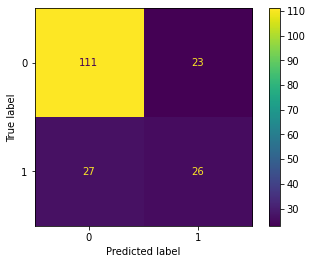

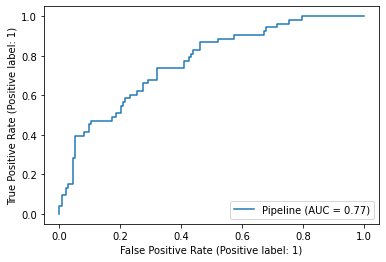

In [92]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=pipeline, X=X_test, y=y_test)

### SVM, 500 threshold

In [166]:
base_model = SVC(probability=True)

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    ('features', feature_union),
    ('model', base_model)
])

In [167]:
params = [
    {
        'features__pca__n_components': [2,3, 4],
        'features__select_best__k': [20, 30, 50],
        'model__C': [0.1, 0.5, 1, 2],
        'model__kernel': ['linear', 'poly','rbf'],
        'model__gamma': [0.01, 0.1, 1]
    }
]

In [168]:
# create grid search
kfolds = 5

grid_search = GridSearchCV(pipeline, param_grid=params,cv=kfolds, verbose=2)

# fit model
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END features__pca__n_components=2, features__select_best__k=20, model__C=0.1, model__gamma=0.01, model__kernel=linear; total time=   0.3s
[CV] END features__pca__n_components=2, features__select_best__k=20, model__C=0.1, model__gamma=0.01, model__kernel=linear; total time=   0.2s
[CV] END features__pca__n_components=2, features__select_best__k=20, model__C=0.1, model__gamma=0.01, model__kernel=linear; total time=   0.2s
[CV] END features__pca__n_components=2, features__select_best__k=20, model__C=0.1, model__gamma=0.01, model__kernel=linear; total time=   0.2s
[CV] END features__pca__n_components=2, features__select_best__k=20, model__C=0.1, model__gamma=0.01, model__kernel=linear; total time=   0.2s
[CV] END features__pca__n_components=2, features__select_best__k=20, model__C=0.1, model__gamma=0.01, model__kernel=poly; total time=   0.2s
[CV] END features__pca__n_components=2, features__select_best__k=20, model__C=0.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('values',
                                        FeatureUnion(transformer_list=[('cat_cols',
                                                                        Pipeline(steps=[('cats',
                                                                                         FunctionTransformer(func=<function catFeat at 0x7fabf68051f0>)),
                                                                                        ('encode',
                                                                                         OneHotEncoder()),
                                                                                        ('densify',
                                                                                         <__main__.ToDenseTransformer object at 0x7fabf680b850>)])),
                                                                       ('num_cols',
                                                         

In [169]:
tuned_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

{'features__pca__n_components': 2, 'features__select_best__k': 20, 'model__C': 0.1, 'model__gamma': 0.01, 'model__kernel': 'linear'}


Train accuracy: 0.743298969072165
Test accuracy: 0.7700534759358288
Train auc: 0.8117738335636093
Test auc: 0.810258064516129
Train precision: 0.75
Test precision: 0.6266666666666667
Train recall: 0.7298969072164948
Test recall: 0.7580645161290323
F1 score train: 0.7398119122257052
F1 score test: 0.6861313868613139
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       125
           1       0.63      0.76      0.69        62

    accuracy                           0.77       187
   macro avg       0.75      0.77      0.75       187
weighted avg       0.79      0.77      0.77       187



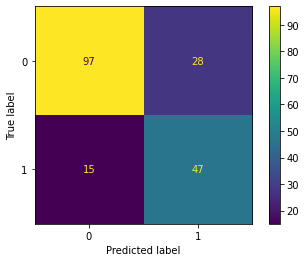

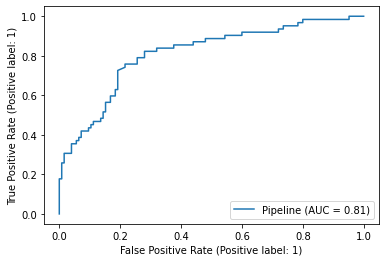

In [171]:
# evaluate
xg = tuned_model

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

plot_roc_curve(estimator=xg, X=X_test, y=y_test)

In [173]:
import pickle

filename = 'classification_model.sav'
pickle.dump(xg, open(filename, 'wb'))

load_model = pickle.load(open(filename, 'rb'))

y_pred = load_model.predict(X_test)
test_acc = xg.score(X_test, y_test)
print(test_acc)

0.7700534759358288
